In [21]:
from pathlib import Path
from imitative_agent import ImitativeAgent
import pickle
import yaml
import matplotlib.pyplot as plt

model_path = Path('../out/imitative_agent/babbling_v2')
basenames = ['classic_with_babblings', 'classic']

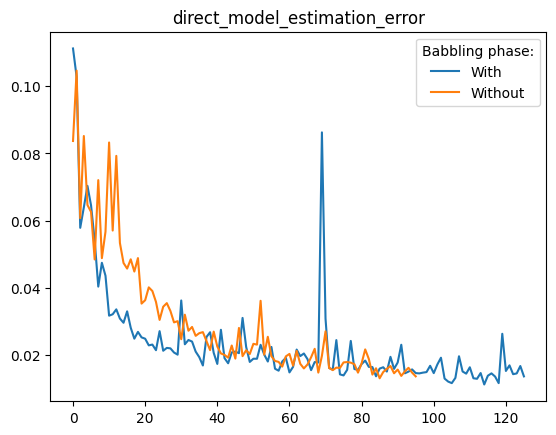

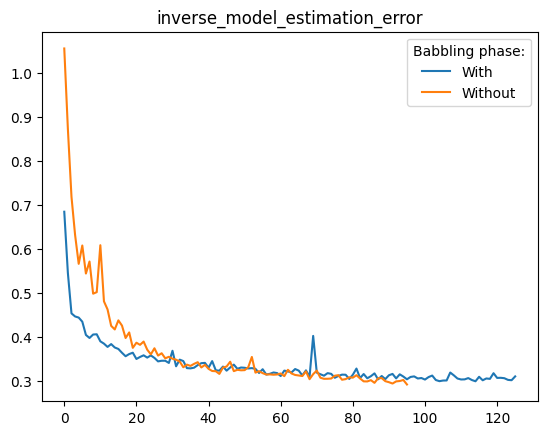

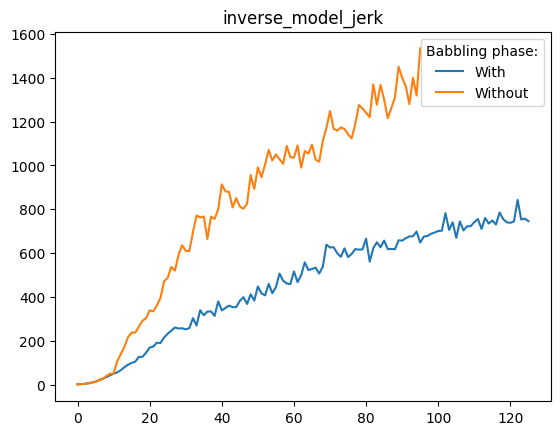

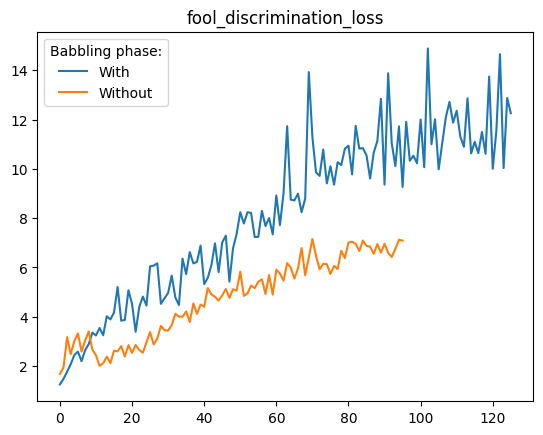

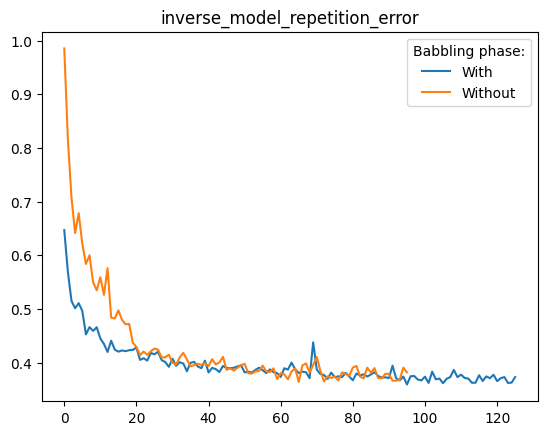

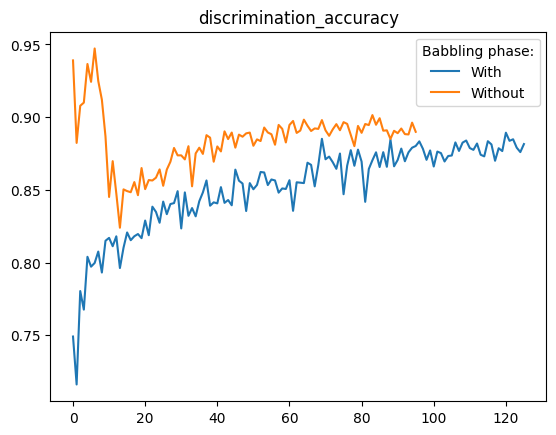

In [22]:
# Compare losses
groups_metrics = {}
for basename in basenames:
    agent_path = model_path / basename
    agent = ImitativeAgent.reload(str(agent_path), load_nn=False)
    config = agent.config
    with open("%s/metrics.pickle" % agent_path, "rb") as f:
        metrics = pickle.load(f)
    
    group_name = "\n".join((
        f"{','.join(config['dataset']['names'])}",
    ))
    
    if group_name not in groups_metrics:
        groups_metrics[group_name] = {}
    groups_metrics[group_name][str(agent_path)] = metrics
    
labels = ['With', 'Without']
loss_names = ['direct_model_estimation_error', 'inverse_model_estimation_error', 'inverse_model_jerk',
             'fool_discrimination_loss', 'inverse_model_repetition_error', 'discrimination_accuracy']
for loss_name in loss_names:
    for i, basename in enumerate(basenames):
        agent_path = str(model_path / basename)
        losses = groups_metrics['pb2007'][agent_path]
        plt.plot(losses['validation'][loss_name], label=labels[i])
    plt.legend(title='Babbling phase:')
    plt.title(loss_name)
    plt.show()

In [20]:
# Compare MSE
from tqdm import tqdm
from lib.dataset_wrapper import Dataset
import numpy as np

def get_test_mse(agent):
    labels = ['LI', 'TT', 'TM', 
              'TB', 'LL', 'UL']
    dataset_name = agent.config['dataset']['names'][0]
    dataset = Dataset(dataset_name)
    items_name = agent.datasplits[dataset_name][2]
    items_sound = dataset.get_items_data(agent.config['dataset']['sound_type'], cut_silences=True)
    items_art = dataset.get_items_data('art_params', cut_silences=True)
    mse = {l: [] for l in labels}
    for item_name in items_name:
        item_sound = items_sound[item_name]
        art_estimated = agent.repeat(item_sound)['art_estimated']
        art_real = items_art[item_name]
        if art_real.shape != art_estimated.shape:
            print(f"Inferred and gold articulatory trajectories should be the same size." \
                  f"Got {art_real.shape} for gold trajectories and {art_estimated.shape} for estimated ones.")
            break
            
        mse_item = ((art_real - art_estimated)**2).mean(axis=0)
        for i, label in enumerate(labels):
            mse[label].append(mse_item[i])
    mse['ave'] = np.mean([mse[label] for label in labels], axis=0)
    return mse

all_mse = {}
for basename in tqdm(basenames):
    agent_path = model_path / basename
    agent = ImitativeAgent.reload(str(agent_path))
    mse = get_test_mse(agent)
    all_mse[agent_path] = mse
    print(f"MSE_art {basename}:", np.mean(all_mse[agent_path]['ave']))

 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.30s/it]

MSE_art classic_with_babblings_v2: 20.570408


100%|█████████████████████████████████████████████| 2/2 [00:04<00:00,  2.21s/it]

MSE_art classic: 22.432644


In [24]:
# Compute ABX
from lib import utils
from lib import abx_utils
ABX_NB_SAMPLES = 200
distance = {
        "art_estimated": {
            "metric": "cosine",
            "weight": 1,
        },
    }

# Create alias
agents_alias = {}
for basename in basenames:
    agent_path = model_path / basename
    agent = ImitativeAgent.reload(str(agent_path), load_nn=False)
    config = agent.config
        
    agent_alias = " ".join((
        f"path={agent_path}",
    ))
    agents_alias[agent_alias] = agent_path
    
# Compute ABX 
agents_abx_matrices = utils.pickle_load(model_path / 'abx_cache.pickle', {})
for agent_alias, agent_path in tqdm(agents_alias.items()):
    if agent_path not in agents_abx_matrices:
        agents_abx_matrices[agent_path] = {}
    agent_abx_matrices = agents_abx_matrices[agent_path]
    
    distance_signature = abx_utils.get_distance_signature(distance)
    #if distance_signature in agent_abx_matrices: continue
        
    agent = ImitativeAgent.reload(str(agent_path))
    
    main_dataset = agent.get_main_dataset()
    agent_lab = agent.get_datasplit_lab(2)
    agent_features = agent.repeat_datasplit(2)
    
    consonants = main_dataset.phones_infos["consonants"]
    vowels = main_dataset.phones_infos["vowels"]
    consonants_indexes = abx_utils.get_datasets_phones_indexes(agent_lab, consonants, vowels)
    abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, agent_features, distance, ABX_NB_SAMPLES, seed=43)
    agent_abx_matrices[distance_signature] = abx_matrix
    utils.pickle_dump(model_path / 'abx_cache.pickle', agents_abx_matrices)
    
for basename in basenames:
    agent_path = model_path / basename
    distance_signature = abx_utils.get_distance_signature(distance)
    agent_abx_matrix = agents_abx_matrices[agent_path][distance_signature]
    groups_score = abx_utils.get_groups_score(consonants, agent_abx_matrix, main_dataset.phones_infos["consonant_groups"])
    global_score = abx_utils.get_global_score(agent_abx_matrix)
    print(agent_path, groups_score)
    print(agent_path, global_score)

100%|█████████████████████████████████████████████| 2/2 [00:31<00:00, 15.64s/it]

../out/imitative_agent/babbling_v2/classic_with_babblings {'manner': 82.30833333333332, 'place': 75.68750000000001}
../out/imitative_agent/babbling_v2/classic_with_babblings 85.1374269005848
../out/imitative_agent/babbling_v2/classic {'manner': 80.21666666666668, 'place': 65.83333333333333}
../out/imitative_agent/babbling_v2/classic 82.28070175438596


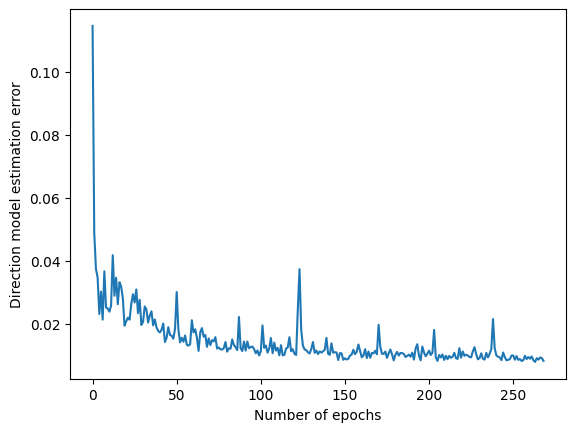

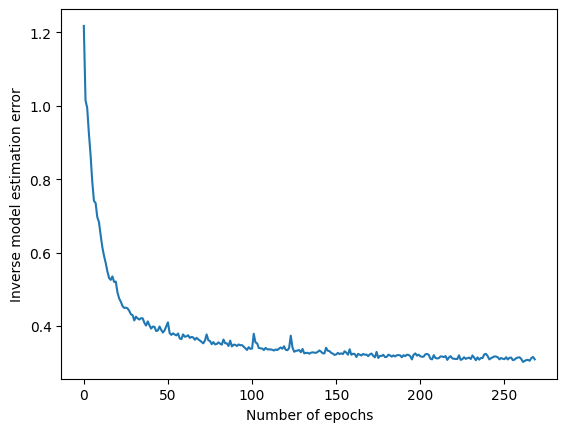

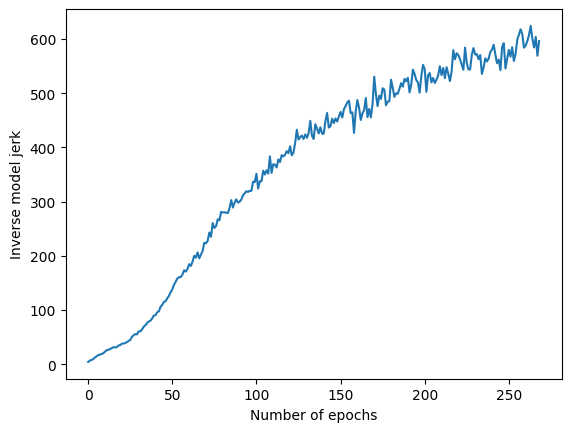

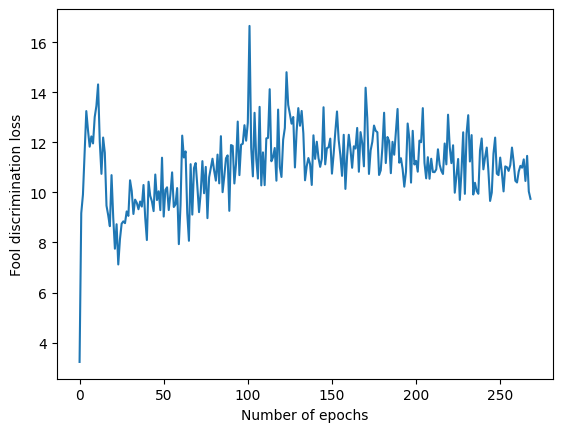

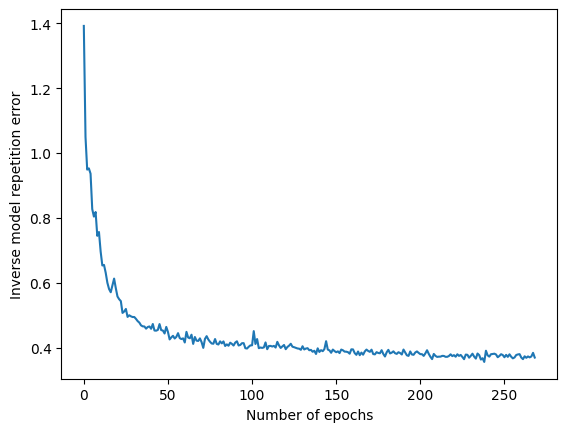

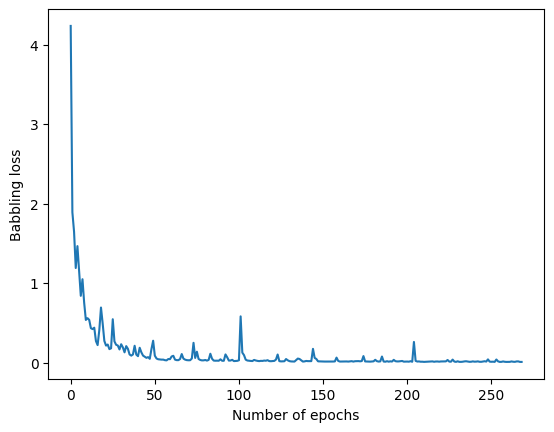

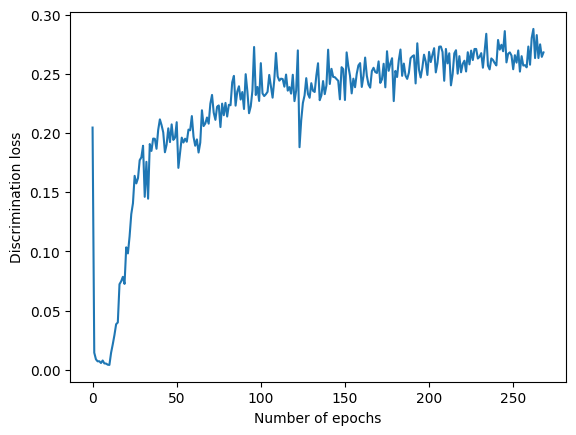

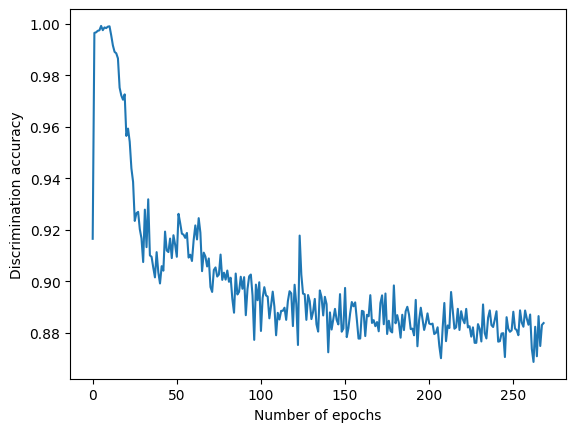

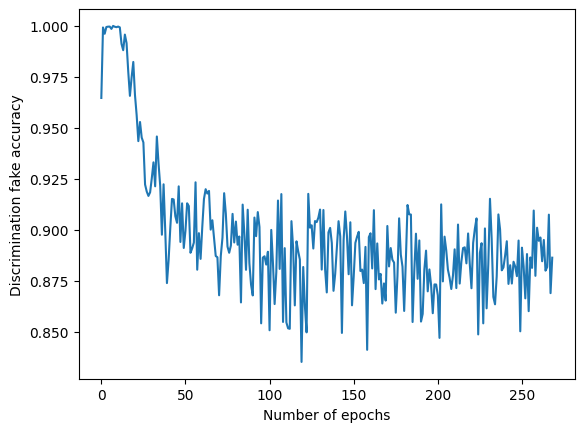

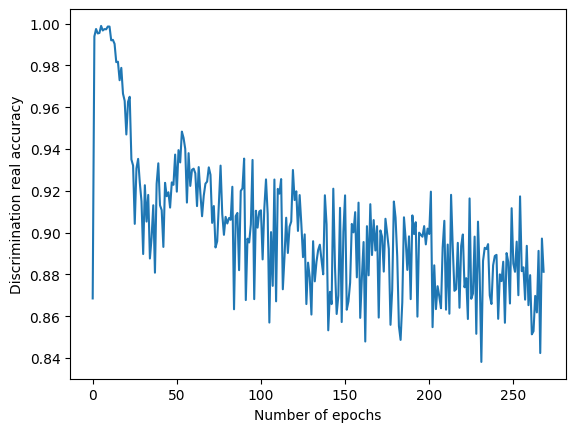

In [15]:
agent_path = "../out/imitative_agent/babbling_v2/classic_with_babblings"
agent = ImitativeAgent.reload(str(agent_path), load_nn=False)
config = agent.config
with open("%s/metrics.pickle" % agent_path, "rb") as f:
    metrics = pickle.load(f)

group_name = "\n".join((
    f"{','.join(config['dataset']['names'])}",
))

if group_name not in groups_metrics:
    groups_metrics[group_name] = {}
groups_metrics[group_name][str(agent_path)] = metrics

ylabel_dict = {
    'direct_model_estimation_error': 'Direction model estimation error',
    'inverse_model_estimation_error': 'Inverse model estimation error',
    'inverse_model_jerk': 'Inverse model jerk',
    'fool_discrimination_loss': 'Fool discrimination loss',
    'discrimination_loss': 'Discrimination loss',
    'inverse_model_repetition_error': 'Inverse model repetition error',
    'babbling_loss': 'Babbling loss', 
    'discrimination_accuracy': 'Discrimination accuracy',
    'discrimination_fake_accuracy': 'Discrimination fake accuracy',
    'discrimination_real_accuracy': 'Discrimination real accuracy'
}
for loss in groups_metrics['pb2007'][agent_path]['validation'].keys():
    plt.plot(groups_metrics['pb2007'][agent_path]['validation'][loss])
    plt.ylabel(ylabel_dict[loss])
    plt.xlabel("Number of epochs")
    plt.show()
    

In [16]:
from pathlib import Path
from imitative_agent import ImitativeAgent
import pickle
import yaml
import matplotlib.pyplot as plt
from tqdm import tqdm
from lib.dataset_wrapper import Dataset
import numpy as np

# Check perf on babbling dataset
agent_path = '../out/imitative_agent/babbling_v2/classic_with_babblings'
agent = ImitativeAgent.reload(str(agent_path))
dataset_name = agent.config['babbling_dataset']['name']
dataset = Dataset(dataset_name)
items_name = agent.bab_datasplits[0]
items_sound = dataset.get_items_data(agent.config['dataset']['sound_type'], cut_silences=True)
items_art = dataset.get_items_data('art_params', cut_silences=True)
labels = ['LI', 'TT', 'TM', 'TB', 'LL', 'UL']
mse = {l: [] for l in labels}
for item_name in items_name:
    item_sound = items_sound[item_name]
    art_estimated = agent.repeat(item_sound)['art_estimated']
    art_real = items_art[item_name]
    if art_real.shape != art_estimated.shape:
        print(f"Inferred and gold articulatory trajectories should be the same size." \
              f"Got {art_real.shape} for gold trajectories and {art_estimated.shape} for estimated ones.")
        break

    mse_item = ((art_real - art_estimated)**2).mean(axis=0)
    for i, label in enumerate(labels):
        mse[label].append(mse_item[i])
mse['ave'] = np.mean([mse[label] for label in labels], axis=0)
print(mse['ave'].mean())

[  0.4329108 -53.659214   12.090698   -7.95819    26.51355     8.364093 ]
[  9.699274  64.85717    2.663078  -7.574747 -20.401691  -8.49023 ]
[ 15.022589  -61.86017   -10.913772    6.1576796  20.039654  -12.6510935]
[  8.607443   -52.108894     0.26611856  -6.5337095   69.32785
  -8.143181  ]
[ 11.286225   31.837599   -7.975827   -3.1394904  58.393635  -14.7215   ]
[  5.1868005 -74.76759   -25.306568    7.883537    8.393143   -3.1364832]
[  6.5670915 -50.666508  -20.618526   -2.8870246  67.05925   -10.421257 ]
[ 16.52986    91.71246     6.9945517  -0.808419  -28.356113   -2.8162467]
[ 8.715773   13.848689   -6.383069   -0.87276137 23.759935   -3.1235867 ]
[ 11.933458   15.162695   -8.8692045  -1.0466722 -33.880825   -8.24967  ]
[ -2.8321905 -80.13888    27.863405   14.908974   53.054466   -5.6190987]
[ -3.1195827 -73.607155   32.78045     7.833241   67.159035   -7.647799 ]
[ 12.058617   61.71946     6.2887707   9.57367   -42.023376   -6.1758356]
[  9.774396 -62.114494 -22.186253   4.98

[ 1.2083429e+01  7.9156258e+01 -1.8502605e+00  6.6393755e-02
 -1.5099247e+01  1.3380171e+00]
[ -7.070356  37.25414  -38.874     17.463093  40.16104   -2.258603]
[  5.608729  -13.877446  -16.774279   -1.2155926  30.49128    -3.0341775]
[ 11.9993515  -7.9780354 -21.818264    1.1192404 -28.634287   -4.4280815]
[ -2.7995105 -67.38395   -30.260227   -2.9261858  36.49445    -3.191339 ]
[ -2.4853964 -65.493904   45.159397   12.391378   56.52115    -8.152228 ]
[  6.1423793 -66.53103   -24.544958   -9.342841   -3.95847    -2.886657 ]
[ -2.3994157 -50.36296    19.949308   19.767746   58.03323    -3.5000396]
[  1.6779056  87.38822    25.568481   -1.2360202 -22.332808   -8.788214 ]
[  6.1766586 -66.28487   -24.525173   -9.3293705  -4.1703186  -2.9700716]
[  5.4792333 -58.690666  -33.743767   -5.4829545   8.164151   -6.594377 ]
[  1.6586217  87.2541     25.531437   -1.1661536 -22.448559   -8.794919 ]
[  2.1175454  74.18869    37.44444     0.7253514 -28.872267   -6.2665677]
[ -1.4548922 -77.68951   

[ -1.4609247 -77.955925   45.259598   22.244808   62.227367   -9.034278 ]
[ -2.6173935 -64.92618    44.506107   12.957902   56.095486   -8.049119 ]
[ -4.004585  57.04445  -27.993261  19.254013  55.099586  -9.075205]
[ -1.4609036 -77.962524   45.260166   22.24005    62.225475   -9.034144 ]
[  9.722964   64.99514     2.728478   -7.3793344 -20.538473   -8.447857 ]
[ -7.0859485  37.093662  -38.765606   17.43242    39.95711    -2.2533374]
[  4.288191    34.89719    -12.301267     0.77796304 -21.100426
  -0.55692893]
[  5.4013844 -58.050106  -34.22015    -5.5492725   8.337469   -6.7383184]
[  8.796978   56.80776     3.3227632   5.4353137 -34.189278   -9.76259  ]
[ -1.7645983  31.856943   10.774636   15.0552025 -43.53647   -13.850871 ]
[ 16.493053   91.17753     6.7155356  -0.5413063 -28.134695   -2.859053 ]
[ 15.014452  -62.056534  -11.169594    6.1249084  19.926567  -12.562153 ]
[ -3.8335824  42.197453   10.1759205   6.9739995 -42.60051   -10.313182 ]
[  4.2948074   34.765934   -11.641198  

[  8.828629   56.641823    3.3381674   5.508759  -34.280693   -9.887128 ]
[ 12.2151575  30.784113  -10.401343   -4.2123294  52.85581   -20.765158 ]
[ -0.82152945 -39.83641    -32.4128      -4.231265    47.21201
  -6.339528  ]
[  4.2948074   34.765934   -11.641198     0.67569774 -20.821825
  -0.43610746]
[  4.942551    35.188046    -5.165799     3.894009   -29.947502
  -0.16787595]
[  2.567686  25.54912    7.885809 -15.841953  65.444885 -11.009554]
[  5.699541  -13.3418455 -16.888426   -1.0855155  30.731327   -3.2308636]
[ 11.793336   -8.422453  -21.685827    1.0922515 -28.643246   -4.3672976]
[  5.3341126   40.829823    -8.081504    -0.29234138 -19.993565
   5.4185104 ]
[  0.42189875 -53.193268    12.093736    -7.9125338   25.96943
   8.567532  ]
[  9.497237     6.077229   -28.247507    -0.76870567 -20.751095
  -5.4998074 ]
[ 12.09421    79.69693    -1.9499929  -0.2254915 -14.991401    1.5262996]
[  9.863247 -62.731655 -22.486284   5.245854  18.368908 -15.178674]
[  6.15615   -66.29970

[  5.126095    35.96589     -5.8926296    4.0413604  -30.301317
  -0.19757992]
[ -3.9455185  57.05253   -27.968607   19.194511   55.628258   -9.018795 ]
[ 11.602712   -8.811671  -21.56776     1.1295182 -28.586624   -4.291415 ]
[  5.4329762  22.441916  -17.413677   -5.6134014  57.21915   -19.684017 ]
[  9.790104 -62.19241  -22.16801    4.973713  18.879637 -15.118571]
[ -1.4550143 -77.75928    45.244843   22.303411   62.243538   -9.030861 ]
[  5.3416305   40.809498    -8.012544    -0.28850156 -19.973715
   5.483174  ]
[  6.6086273 -50.59368   -20.656734   -2.8443038  66.980225  -10.344765 ]
[ 12.071734   61.75205     6.1787195   9.543102  -42.132454   -6.0014124]
[  6.228085  -66.52923   -24.313053   -9.304699   -3.6427052  -2.649106 ]
[ 10.321601  -18.737568  -34.03205     1.5443901 -37.435123   -9.408684 ]
[ -1.4592173 -77.24747    45.203354   22.356682   62.153355   -9.015109 ]
[ 16.529873   91.64327     6.919102   -0.776076  -28.315863   -2.8300235]
[ -3.8577256 -63.804974   28.17027

[ 15.529731   15.238387   -0.8748246  -0.5548977 -17.911057   -4.4814644]
[ -3.6746233 -63.259453   28.533224   12.783706   63.14758   -11.041187 ]
[ -2.6053984 -65.135864   44.61786    12.805577   56.252888   -8.082262 ]
[ -1.2678794 -58.677094  -22.44648    -4.7830944  43.780262   -2.3339698]
[  1.6700848  87.28516    25.54414    -1.1737448 -22.43301    -8.793503 ]
[  3.195515   53.442135    7.2560143 -16.23133    71.038216  -10.676254 ]
[ 17.376791   95.6603     13.413264   -4.1374755 -20.934849   -1.2381896]
[ -1.7936428  31.924854   10.647111   15.109313  -43.41911   -13.876945 ]
[  5.041592   34.62866    -5.1594086   4.1495123 -30.318169   -0.5161236]
[  4.2645903   34.89779    -12.34048      0.78059226 -21.101515
  -0.5148752 ]
[  5.02967     35.258286    -5.548477     4.022876   -30.291836
  -0.48412737]
[-3.7584372 66.38927    9.469652   6.331396  44.943733  -9.646759 ]
[  9.509918    5.8131466 -28.251713   -0.7630781 -20.704357   -5.441013 ]
[ 7.8014565 14.951953  -7.8288555 

[  5.718301  -13.296507  -16.895311   -1.0827304  30.740246   -3.246383 ]
[ 10.313094  -18.59566   -33.86692     1.5243418 -37.553337   -9.434928 ]
[ -2.4724085 -65.57547    45.182663   12.388165   56.543976   -8.149774 ]
[  4.997413   35.39756    -5.504348    3.9524493 -30.1196     -0.2928033]
[-3.7566707 66.47431    9.533194   6.364567  45.089176  -9.738946 ]
[ 8.735536  13.7803955 -6.441307  -0.8975742 23.931292  -3.1506722]
[ 10.762946   46.67505   -12.339007   11.1293955 -33.32471    -9.443106 ]
[  0.5122781 -55.899376   12.475916   -8.217528   28.985435    7.3990607]
[  5.334477    40.15259     -7.8234634   -0.12975428 -19.892504
   5.4424534 ]
[ 17.187397   94.205414   13.781498   -4.0567865 -20.837334   -1.1893821]
[  0.57206935  48.265965    23.681824    11.272754   -43.06948
 -12.497648  ]
[  7.0534587  -32.991505   -33.49813      0.87317634  28.351713
  -4.064393  ]
[ -3.9993076  57.028133  -28.039583   19.310858   55.101387   -9.096565 ]
[  2.1159708  74.183876   37.474895 

[  5.492894  -59.728867  -33.683605   -5.4729323   8.334257   -6.46204  ]
[  4.2948074   34.765934   -11.641198     0.67569774 -20.821825
  -0.43610746]
[  2.1212869  74.15519    37.450485    0.7280923 -28.865168   -6.266754 ]
[ -4.1504564  57.94504   -23.62454    18.585072   63.98149   -13.704883 ]
[  5.434726   22.45358   -17.402092   -5.6166496  57.22749   -19.671532 ]
[  4.0559225  -69.96727      7.690185    -0.52994955  46.835983
  -3.396567  ]
[ 15.519709   15.202407   -0.8786387  -0.5621795 -17.911484   -4.4675   ]
[  5.6675215 -13.456571  -16.878454   -1.1278654  30.73628    -3.175458 ]
[  2.1214652  74.141335   37.461063    0.7282281 -28.85937    -6.2660947]
[  4.292168   34.79185   -11.738823    0.6864219 -20.85039    -0.4643286]
[ 17.371801   95.4827     13.408277   -4.155243  -20.958057   -1.2309041]
[ -2.475796 -65.54372   45.17638   12.388638  56.530087  -8.151862]
[ -3.3334248  36.545944    5.2376003  12.393834  -40.39547    -9.53334  ]
[  1.6441851  23.798222   10.86739

[ 15.886138    15.215976    -1.2675188   -0.36215076 -17.50462
  -5.0214844 ]
[ 10.249146  -18.524427  -34.041634    1.5804546 -37.602158   -9.418705 ]
[  9.5021      5.766218  -28.380821   -0.6788535 -20.574905   -5.4728565]
[ 12.079751   61.623978    6.317646    9.555901  -42.044872   -6.1884637]
[ 15.627522   15.485663   -0.8826327  -0.4891244 -17.862673   -4.6393676]
[  8.7986965  56.8388      3.321339    5.3942776 -34.11037    -9.498556 ]
[ -6.52794   45.670174 -30.065216  16.403929  47.71189   -7.956538]
[ -3.995101  57.02907  -28.049658  19.305931  55.115265  -9.091481]
[ -7.0776334  37.176453  -38.815384   17.44785    40.061867   -2.2564032]
[  0.49448693  48.229534    23.516012    11.259854   -43.10234
 -12.77685   ]
[  5.0032725   35.434155    -5.536787     3.955365   -30.125383
  -0.28518844]
[ -4.1956496  57.92155   -23.638597   18.668953   64.12883   -13.723101 ]
[  7.8870893  -18.174616   -19.47299     -0.83501136  22.129648
  -2.4326897 ]
[ 15.546542    15.298384    -0.8

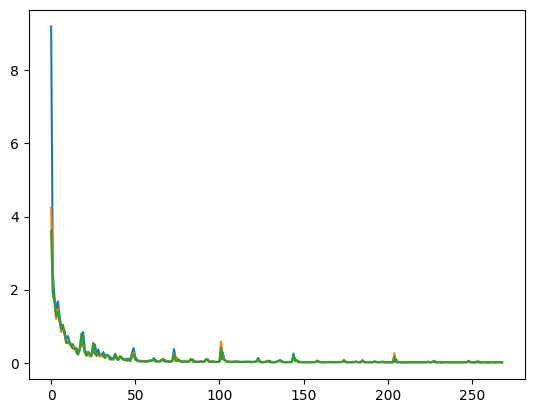

In [13]:
with open("%s/metrics.pickle" % agent_path, "rb") as f:
    metrics = pickle.load(f)
plt.plot(metrics['train']['babbling_loss'])
plt.plot(metrics['validation']['babbling_loss'])
plt.plot(metrics['test']['babbling_loss'])

In [29]:
# Load agent



agents_abx_matrices = utils.pickle_load(model_path / 'abx_cache.pickle', {})
for basename in basenames:
    agent_path = model_path / basename
    if agent_path not in agents_abx_matrices:
        agents_abx_matrices[agent_path] = {}
    agent_abx_matrices = agents_abx_matrices[agent_path]
    
    agent = ImitativeAgent.reload(str(agent_path))
    # Load vowels and consonants info
    main_dataset = agent.get_main_dataset()
    consonants = main_dataset.phones_infos["consonants"]
    in_consonants = ['b', 'm', 'd', 'n', 'g']
    out_consonants = set(consonants) - set(in_consonants)
    vowels = main_dataset.phones_infos["vowels"]
    in_vowels = ['a', 'e^', 'e', 'x', 'x^', 'e~', 'y', 'u', 'o~', 'a~']
    out_vowels = set(vowels) - set(in_vowels)

    consonant_babbling_groups = {
        'in_consonant_babbling': in_consonants,
        'out_consonant_babbling': out_consonants
    }

    vowel_babbling_groups = {
        'in_vowel_babbling': in_vowels,
        'out_vowel_babbling': out_vowels
    }


    # Compute ABX on VCV triplets
    distance_signature = abx_utils.get_distance_signature(distance)
    agent_lab = agent.get_datasplit_lab(2)
    agent_features = agent.repeat_datasplit(2)
    consonants_indexes = abx_utils.get_datasets_phones_indexes(agent_lab, consonants, vowels)
    abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, agent_features, distance, ABX_NB_SAMPLES, seed=43)
    agent_abx_matrices[distance_signature] = abx_matrix
    utils.pickle_dump(model_path / 'abx_cache.pickle', agents_abx_matrices)
    
for basename in basenames:
    agent_path = model_path / basename
    distance_signature = abx_utils.get_distance_signature(distance)
    agent_abx_matrix = agents_abx_matrices[agent_path][distance_signature]
    in_out_score = abx_utils.get_groups_score(consonants, agent_abx_matrix, consonant_babbling_groups)
    place_manner_score = abx_utils.get_groups_score(consonants, agent_abx_matrix, main_dataset.phones_infos["consonant_groups"])
    global_score = abx_utils.get_global_score(agent_abx_matrix)
    print(agent_path, groups_score)
    print(agent_path, global_score)

FileNotFoundError: [Errno 2] No such file or directory: '../out/imitative_agent/babbling_v2/classig_with_babblings/config.yaml'